### Tutorial in hamiltorch for log probabilities

* For the corresponding blog post please see: https://adamcobb.github.io/journal/hamiltorch.html
* Bayesian neural networks are left to a different notebook 

In [4]:
#notes for setting by Hyunji

#install
# - git clone the following repo in google drive/Colab Notebook folder
# - go to browser google drive/Colab Notebook and open this notebook with colab (right click)
# - 
# !pip3 install git+https://github.com/hyunjimoon/hamiltorch

# to edit the python files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# add hamiltorch for edit purpose (RUN THIS CELL ARTER .py EDIT!)
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/hamiltorch')
import hamiltorch
#/content/drive/MyDrive/Colab Notebooks/hamiltorch import hamiltorch

Mounted at /content/drive


In [5]:
import torch
#import hamiltorch 
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
print(hamiltorch.__version__)

0.4.0.dev1


## Sampling a multivariate Gaussian

In `hamiltorch`, we have designed the samplers to receive a function handle `log_prob_func`, which the sampler will use to evaluate the log probability of each sample. A `log_prob_func` must take a 1-d vector of length equal to the number of parameters that are being sampled. For the example of our multivariate Gaussian distribution, we can define our `log_prob_func` as follows:

In [8]:
def log_prob(omega):
    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.]) 
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

In [9]:
N = 400
step_size = .3
L = 5

### Sample using standard HMC
* Initialise the parameters e.g. `params_init = torch.zeros(3)` and pass them into the `hamiltorch.sample()` function as `params_init=params_init`.
* Set the number of samples `num_samples=N` corresponding to the number of momentum resampling steps/the number of trajectories to sample.
* Set the step size and trajectory length via `step_size=step_size, num_steps_per_sample=L`.

In [10]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec

Acceptance Rate 0.99


### Sample using the No-U-Turn Sampler (NUTS)
* As in Hoffman and Gelman 2011.
* This is set using the additional parameter `sampler=hamiltorch.Sampler.HMC_NUTS`.
* The step size is adapted with the objective of a desired acceptance rate `desired_accept_rate=0.8`.
* The step size is fixed after the burn stage `burn=burn` and we define `N_nuts = burn + N`


In [11]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3) + 5
burn=500
N_nuts = burn + N
params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
                                                  sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
                                                  desired_accept_rate=0.8)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Final Adapted Step Size:  0.7333879470825195

Acceptance Rate 0.78


### Sample using implicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* As in Girolami and Calderhead 2011.
* Switch the sampler via setting `sampler=hamiltorch.Sampler.RMHMC` and the integrator via `integrator=hamiltorch.Integrator.IMPLICIT`.
* Limit the number of fixed point iterations in the generalised leapforg via `fixed_point_max_iterations=1000` and set the convergence threshold for 'breaking out' of the while loop via `fixed_point_threshold=1e-05`.


In [12]:
# Implicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_irmhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.IMPLICIT, fixed_point_max_iterations=1000,
                                  fixed_point_threshold=1e-05)

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec

Acceptance Rate 0.99


### Sample using explicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* As in Cobb et. al. 2019
* Switch the integrator to explicit via `integrator=hamiltorch.Integrator.EXPLICIT`. Note that the sampler is still set to RMHMC.
* Introduce and set the binding term via `explicit_binding_const=omega`. This can be subsequently optimised for the highest acceptance rate.



In [13]:
# Explicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
omega = 100.
params_ermhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.EXPLICIT, explicit_binding_const=omega)

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec

Acceptance Rate 0.99


In [14]:
# Hyperelliptical RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
omega = 100.
params_hermhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size, num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.EXPLICIT, explicit_binding_const=omega, metric = hamiltorch.Metric.HYPERELLIP)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [ 0.0000,  0.0000, -0.2500]], grad_fn=<CopySlices>)
params: tensor([ 0.0699,  1.1369, -2.9985], requires_grad=True)
hess: tensor([[-4.0000,  0.0000,  0.0000],
        [ 0.0000, -1.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2500]], grad_fn=<CopySlices>)
params: tensor([ 0.0699,  1.1369, -2.9985], requires_grad=True)
hess: tensor([[-4.0000,  0.0000,  0.0000],
        [ 0.0000, -1.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2500]], grad_fn=<CopySlices>)
params: tensor([ 0.0699,  1.1369, -2.9985], requires_grad=True)
hess: tensor([[-4.0000,  0.0000,  0.0000],
        [ 0.0000, -1.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2500]], grad_fn=<CopySlices>)
params: tensor([ 0.0699,  1.1369, -2.9985], requires_grad=True)
hess: tensor([[-4.0000,  0.0000,  0.0000],
        [ 0.0000, -1.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2500]], grad_fn=<CopySlices>)
params: tensor([ 0.0699,  1.1369, -2.9985], requires_grad=True)
hess: tensor([[-4.0000, 

### Convert samples to numpy arrays to plot using matplotlib

In [15]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_nuts = torch.cat(params_hmc_nuts).reshape(len(params_hmc_nuts),-1).numpy()
coords_i_rmhmc = torch.cat(params_irmhmc).reshape(len(params_irmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_ermhmc).reshape(len(params_ermhmc),-1).numpy()
coords_h_e_rmhmc = torch.cat(params_hermhmc).reshape(len(params_hermhmc),-1).numpy()

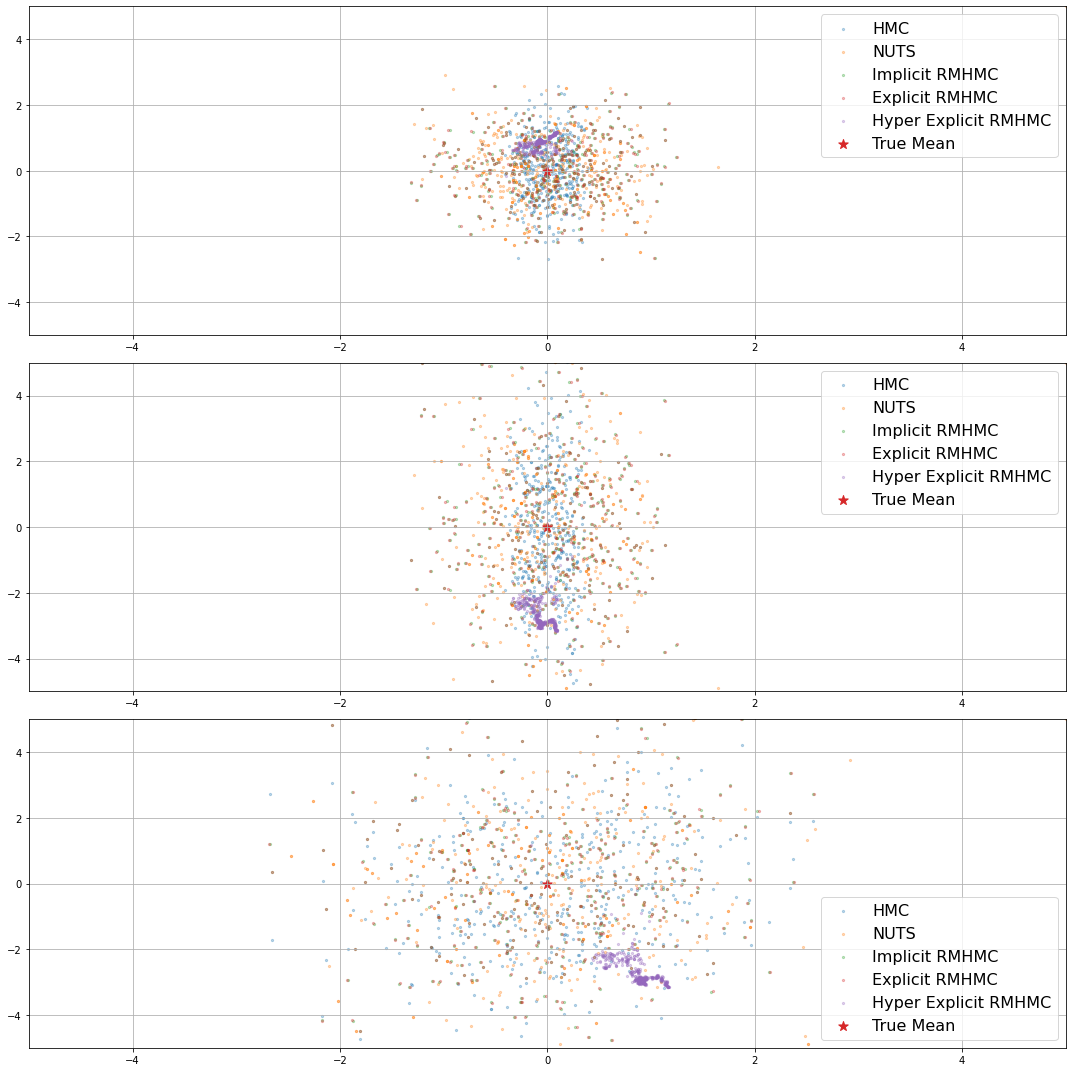

In [16]:
xlim = [-5,5]
ylim = [-5,5]
fs=16
mean = torch.tensor([0.,0.,0.])
stddev = torch.tensor([.5,1.,2.])

fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].scatter(coords_hmc[:,0], coords_hmc[:,1],s=5,alpha=0.3,label='HMC')
axs[0].scatter(coords_nuts[:,0], coords_nuts[:,1],s=5,alpha=0.3,label='NUTS')
axs[0].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,1],s=5,alpha=0.3,label='Implicit RMHMC')
axs[0].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,1],s=5,alpha=0.3,label='Explicit RMHMC')
axs[0].scatter(coords_h_e_rmhmc[:,0], coords_h_e_rmhmc[:,1],s=5,alpha=0.3,label='Hyper Explicit RMHMC')
axs[0].scatter(mean[0],mean[1],marker = '*',color='C3',s=100,label='True Mean')
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].scatter(coords_hmc[:,0], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[1].scatter(coords_nuts[:,0], coords_nuts[:,2],s=5,alpha=0.3,label='NUTS')
axs[1].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[1].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[1].scatter(coords_h_e_rmhmc[:,0], coords_h_e_rmhmc[:,2],s=5,alpha=0.3,label='Hyper Explicit RMHMC')
axs[1].scatter(mean[0],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[1].legend(fontsize=fs)
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

axs[2].scatter(coords_hmc[:,1], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[2].scatter(coords_nuts[:,1], coords_nuts[:,2],s=5,alpha=0.3,label='NUTS')
axs[2].scatter(coords_i_rmhmc[:,1], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[2].scatter(coords_e_rmhmc[:,1], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[2].scatter(coords_h_e_rmhmc[:,1], coords_h_e_rmhmc[:,2],s=5,alpha=0.3,label='Hyper Explicit RMHMC')
axs[2].scatter(mean[1],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[2].legend(fontsize=fs)
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.tight_layout()

# plt.savefig('../../Gaussian_plots.png',bbox_inches='tight')
plt.show()

### KL divergence:
* Calculated the KL divergence as a measure of how well we have approximated the target distribution (the Gaussian).

In [17]:
p = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)
q_hmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_hmc.mean(0)),torch.diag(torch.FloatTensor(coords_hmc.var(0))))
q_nuts = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_nuts.mean(0)),torch.diag(torch.FloatTensor(coords_nuts.var(0))))
q_i_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_i_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_i_rmhmc.var(0))))
q_e_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_e_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_e_rmhmc.var(0))))
q_h_e_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_h_e_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_e_rmhmc.var(0))))

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('NUTS kl:           ',torch.distributions.kl.kl_divergence(p, q_nuts))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))
print('HyperEllip Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_h_e_rmhmc))

HMC kl:             tensor(2.2522)
NUTS kl:            tensor(0.0082)
Implicit RMHMC kl:  tensor(0.0122)
Explicit RMHMC kl:  tensor(0.0124)
HyperEllip Explicit RMHMC kl:  tensor(1.2894)


Experiment until here (02.28)

# Sampling from a more complicated distribution: funnel distribution

* We now define the funnel distribution as in Neal et al. 2003:
$$\prod_i\mathcal{N}(\mathbf{x}_i\vert 0, \exp\{-v\})\mathcal{N}(v\vert 0, 9). $$
* This is our new `log_prob_func`.

In [ ]:
D = 10

def funnel_ll(w, dim=D):
    v_dist = torch.distributions.Normal(0,3)
    ll = v_dist.log_prob(w[0])
    x_dist = torch.distributions.Normal(0,torch.exp(-w[0])**0.5)
    ll += x_dist.log_prob(w[1:]).sum()
    return ll

### Sample using standard HMC
* As we did above for the multivariate Gaussian.

In [ ]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.2 
num_samples = 1000 # For results in plot num_samples = 10000
L = 25

params_hmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L)

### Sample using the No-U-Turn Sampler (NUTS)
* Again, as we did above.
* Note that this log probability is badly defined in certain parts of the parameter space. Therefore you will see invalid log probabilities printed out as the model samples. (Especially in the burn in stage.)
* Do not worry about print statements of `Invalid log_prob`!


In [ ]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.01 
num_samples = 1200 # For results in plot num_samples = 12000
L = 25
burn = 200 # For results in plot burn = 2000

params_hmc_nuts = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,desired_accept_rate=0.75,sampler=hamiltorch.Sampler.HMC_NUTS,burn=burn)



### Sample using implicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)
* We change sampler flag and integrator flag as before.
* For the funnel distribution our metric tensor is no longer guaranteed to be positive semi-definite (PSD) if we use the Hessian as above. Therefore we introduce a new flag and set is as `metric=hamiltorch.Metric.SOFTABS`. This forces our metric to be PSD as in Betancourt 2013.
* As is common in practice, we must often add jitter along the diagonal of the metric tensor to ensure we can invert it (it also allows us to differentiate through it using `torch.symeig`). We do this via `jitter=jitter`.

In [ ]:
# Implicit RMHMC with SOFTABS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0. 
step_size = 0.14 
num_samples = 10 # For results in plot num_samples = 1000, but this takes a while! Setting to 100 is also reasonable.
L = 25
threshold = 1e-3
softabs_const=10**6
fixed_point_max_iterations=1000
jitter= 0.001

params_i_rmhmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.IMPLICIT,
                                   metric=hamiltorch.Metric.SOFTABS, fixed_point_threshold=threshold, jitter=jitter,
                                   num_steps_per_sample=L, step_size=step_size, softabs_const=softabs_const,
                                   fixed_point_max_iterations=fixed_point_max_iterations)



### Sample using explicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* We use our faster integrator with the SOFTABS metric to get a similar result to the implicit integrator.

In [ ]:
# Explicit RMHMC with SOFTABS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.14 
num_samples = 100 # For results in plot num_samples = 1000
L = 25
omega=10
softabs_const=10**6
jitter=0.001

params_e_rmhmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.EXPLICIT,
                                   metric=hamiltorch.Metric.SOFTABS, jitter=jitter,
                                   num_steps_per_sample=L, step_size=step_size, explicit_binding_const=omega, 
                                   softabs_const=softabs_const)

In [ ]:
# Explicit RMHMC with HYPERELLIP
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.14 
num_samples = 100 # For results in plot num_samples = 1000
L = 25
omega=10
softabs_const=10**6
jitter=0.001

params_e_rmhmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.EXPLICIT,
                                   metric=hamiltorch.Metric.HYPERELLIP, jitter=jitter,
                                   num_steps_per_sample=L, step_size=step_size, explicit_binding_const=omega, 
                                   ) #softabs_const=softabs_const

### Convert to numpy arrays for plotting

In [ ]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_hmc_nuts = torch.cat(params_hmc_nuts).reshape(len(params_hmc_nuts),-1).numpy()
coords_i_rmhmc = torch.cat(params_i_rmhmc).reshape(len(params_i_rmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_e_rmhmc).reshape(len(params_e_rmhmc),-1).numpy()

In [ ]:
# One that I made earlier!
params_i_rmhmc = torch.load('../../data/funnel/params_i_rmhmc_10D_funnel_1000.npy')
params_e_rmhmc = torch.load('../../data/funnel/params_e_rmhmc_10D_funnel_1000.npy')
params_hmc = torch.load('../../data/funnel/params_hmc_10D_funnel_10000.npy')
params_hmc_nuts = torch.load('../../data/funnel/params_hmc_nuts_10D_funnel_10000.npy')

coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_hmc_nuts = torch.cat(params_hmc_nuts).reshape(len(params_hmc_nuts),-1).numpy()
coords_i_rmhmc = torch.cat(params_i_rmhmc).reshape(len(params_i_rmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_e_rmhmc).reshape(len(params_e_rmhmc),-1).numpy()

In [ ]:
xlim = [-4,4]
ylim = [0,7]#[-2,9]
text_x = -1.5
text_y = 8
font_size_text = 20
fs=17
vxx = torch.linspace(xlim[0],xlim[1],300)
p = torch.distributions.Normal(0,3)
v_pdf = torch.exp(p.log_prob(vxx))

fig, axs = plt.subplots(1, 4, figsize=(20,5), sharey=True)
axs[0].scatter(coords_hmc[:,1], coords_hmc[:,0],s=5,alpha=0.3,rasterized=True, color='C0', label='HMC')
l = axs[0].legend(loc=0,fontsize=fs)
l.legendHandles[0]._sizes = [100]
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$x_1$',fontsize=font_size_text)
axs[0].set_ylabel(r'$v$',fontsize=font_size_text,rotation=0,labelpad=30)
axs[1].scatter(coords_hmc_nuts[:,1], coords_hmc_nuts[:,0],s=5,alpha=0.3,label='NUTS',rasterized=True,color='C5')

l = axs[1].legend(loc=0,fontsize=fs)
l.legendHandles[0]._sizes = [100]
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$x_1$',fontsize=font_size_text)

axs[2].scatter(coords_i_rmhmc[:,1], coords_i_rmhmc[:,0],s=5,alpha=0.3,rasterized=True, color='C1',label='Implicit\nRMHMC')
l = axs[2].legend(loc=0,fontsize=fs)
l.legendHandles[0]._sizes = [100]
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
axs[2].tick_params(axis='both', labelsize=fs)
axs[2].set_xlabel(r'$x_1$',fontsize=font_size_text)

axs[3].scatter(coords_e_rmhmc[:,1], coords_e_rmhmc[:,0],s=5,alpha=0.3,rasterized=True, color='C2', label='Explicit\nRMHMC')
l = axs[3].legend(loc=0,fontsize=fs)
l.legendHandles[0]._sizes = [100]
axs[3].grid()
axs[3].set_xlim(xlim)
axs[3].set_ylim(ylim)
axs[3].tick_params(axis='both', labelsize=fs)
axs[3].set_xlabel(r'$x_1$',fontsize=font_size_text)

plt.tight_layout()

# plt.savefig('../../data/funnel/funnel_hist_plots_scatter.pdf',bbox_inches='tight')
plt.show()

### Marginal distribution $p(v)$

We can also plot the marginal distributions of $v$ by representing them in histograms. We plot the known Gaussian distribution in each figure for comparison. The KL divergence is also included to measure how close the empirical distribution is from the true one.

In [ ]:
p = torch.distributions.Normal(0,3)
q_hmc = torch.distributions.Normal(coords_hmc[:,0].mean(),coords_hmc[:,0].std())
q_hmc_nuts = torch.distributions.Normal(coords_hmc_nuts[:,0].mean(),coords_hmc_nuts[:,0].std())
q_i_rmhmc = torch.distributions.Normal(coords_i_rmhmc[:,0].mean(),coords_i_rmhmc[:,0].std())
q_e_rmhmc = torch.distributions.Normal(coords_e_rmhmc[:,0].mean(),coords_e_rmhmc[:,0].std())

kl_hmc = torch.distributions.kl.kl_divergence(p, q_hmc)
kl_hmc_nuts = torch.distributions.kl.kl_divergence(p, q_hmc_nuts)
kl_i_rmhmc = torch.distributions.kl.kl_divergence(p, q_i_rmhmc)
kl_e_rmhmc = torch.distributions.kl.kl_divergence(p, q_e_rmhmc)

print('HMC kl:            ',kl_hmc)
print('NUTS HMC kl:       ',kl_hmc_nuts)
print('Implicit RMHMC kl: ',kl_i_rmhmc)
print('Explicit RMHMC kl: ',kl_e_rmhmc)

In [ ]:
xlim = [-9,9]
ylim = [0,.25]
text_x = -4.5
text_y = .233
font_size_text = 20
fs=17
vxx = torch.linspace(xlim[0],xlim[1],300)
p = torch.distributions.Normal(0,3)
v_pdf = torch.exp(p.log_prob(vxx))

fig, axs = plt.subplots(1, 4, figsize=(20,5),sharey=True)
axs[0].hist(coords_hmc[:,0], color='C0', bins=20,density=True, alpha=0.5, label='HMC',range=xlim)
axs[0].plot(vxx.numpy(), v_pdf.numpy(),'C3',label='$p(v)$')
axs[0].legend(loc=0,fontsize=fs)
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].text(text_x, text_y, "$\mathrm{D_{KL}} = $" +  '{:.3f}'.format(kl_hmc), size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
         )
axs[0].set_ylim(ylim)
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$v$',fontsize=font_size_text)
axs[0].set_ylabel(r'$p(v)$',fontsize=font_size_text,rotation=0,labelpad=30)

axs[1].hist(coords_hmc_nuts[:,0], color='C5',bins=20,density=True, alpha=0.5,label='NUTS',range=xlim)
axs[1].plot(vxx.numpy(), v_pdf.numpy(),'C3', label='$p(v)$')
axs[1].legend(loc=0,fontsize=fs)
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].text(text_x, text_y, "$\mathrm{D_{KL}} = $" +  '{:.3f}'.format(kl_hmc_nuts), size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
           )
axs[1].set_ylim(ylim)
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$v$',fontsize=font_size_text)

axs[2].hist(coords_i_rmhmc[:,0], color='C1',bins=20,density=True, alpha=0.5,label='Implicit\nRMHMC')
axs[2].plot(vxx.numpy(), v_pdf.numpy(),'C3', label='$p(v)$')
axs[2].legend(loc=1,fontsize=fs)
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].text(text_x, text_y, "$\mathrm{D_{KL}} = $" +  '{:.3f}'.format(kl_i_rmhmc), size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
         )
axs[2].set_ylim(ylim)
axs[2].tick_params(axis='both', labelsize=fs)
axs[2].set_xlabel(r'$v$',fontsize=font_size_text)

axs[3].hist(coords_e_rmhmc[:,0], color='C2',bins=20,density=True, alpha=0.5, label='Explicit\nRMHMC')
axs[3].plot(vxx.numpy(), v_pdf.numpy(),'C3',label='$p(v)$')
axs[3].legend(loc=0,fontsize=fs)
axs[3].grid()
axs[3].set_xlim(xlim)
axs[3].text(text_x, text_y, "$\mathrm{D_{KL}} = $" +  '{:.3f}'.format(kl_e_rmhmc), size=font_size_text, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec="k", # Outer colour
                   fc='w',
                   )
         )
axs[3].set_ylim(ylim)
axs[3].tick_params(axis='both', labelsize=fs)
axs[3].set_xlabel(r'$v$',fontsize=font_size_text)

plt.tight_layout()

# plt.savefig('../../data/funnel/funnel_hist_plots_nuts.pdf',bbox_inches='tight')
plt.show()

### DEBUG MODE
* For `hamiltorch.sample()` we can pass `debug=True`. This is useful for checking how many iterations RMHMC takes to converge and also to look at the values of the Hamiltonian.
* Also, for NUTS, debug mode returns an EXTRA output corresponding to the adapted step size.

In [ ]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0.
step_size = 0.01 
num_samples = 6 #In paper: 12000
L = 25
burn = 3 #2000

############
debug = True
############

params_hmc_nuts, adapted_step_size = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init,
                                                       num_samples=num_samples, step_size=step_size, 
                                                       num_steps_per_sample=L,desired_accept_rate=0.75,
                                                       sampler=hamiltorch.Sampler.HMC_NUTS,burn=burn, debug=debug)


* DEBUG Mode for implicit RMHMC.

In [ ]:
# Implicit RMHMC with SOFTABS
hamiltorch.set_random_seed(123)
params_init = torch.ones(D + 1)
params_init[0] = 0. 
step_size = 0.14 
num_samples = 2
L = 25
threshold = 1e-3
softabs_const=10**6
fixed_point_max_iterations=1000
jitter= 0.001

############
debug = True
############

params_i_rmhmc = hamiltorch.sample(log_prob_func=funnel_ll, params_init=params_init, num_samples=num_samples,
                                   sampler=hamiltorch.Sampler.RMHMC, integrator=hamiltorch.Integrator.IMPLICIT,
                                   metric=hamiltorch.Metric.SOFTABS, fixed_point_threshold=threshold, jitter=jitter,
                                   num_steps_per_sample=L, step_size=step_size, softabs_const=softabs_const,
                                   fixed_point_max_iterations=fixed_point_max_iterations,debug=debug)

The print statements below show how many iterations each implicit Euler integrator took before breaking out the loop:

```Converged (params), iterations: 3, params_diff: 0.00030622229678556323
 Converged (momentum), iterations: 2, momenta_diff: 0.0001082777525880374```

Therefore here, the `params` fixed-point step took 3 iterations and the `momentum` took 2.